In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
import capo.linsolve
from scipy.sparse import csr_matrix
from tqdm import tqdm
import capo.omni as omni
from copy import deepcopy
#import seaborn
%matplotlib notebook 

# Settings

In [54]:
pol = 'yy'
xants = [81]
dataFile = 'zen.2457678.39660.yy.HH.uvc'
firstCalFile = 'zen.2457678.39660.yy.HH.uvc.fc.npz'
calfile = 'hsa7458_v001'
minFreq, maxFreq = .108, .192
#minFreq, maxFreq = .1, .2

# Load Data and Apply FirstCal

In [3]:
meta,data,flags = miriad.read_files([dataFile],'cross',pol)
fcm,fcg,fcv,fcx = omni.from_npz(firstCalFile)
fcData = deepcopy(data)
for (ant1,ant2) in fcData.keys():
    if ant1 not in xants and ant2 not in xants:
        fcData[(ant1,ant2)][pol] /= (fcg[pol[0]][ant1] * np.conj(fcg[pol[0]][ant2]))    
freqs = meta['freqs']
nint, nchan = data.values()[0].values()[0].shape
antNames = np.sort(fcg.values()[0].keys())
aa = a.cal.get_aa(calfile, freqs)

# Omnical Data and Excise RFI

In [4]:
info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])
reds = info.get_reds()
antNames = [i for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants]
g0 = {pol[0]: {ant: np.ones((nint,nchan),dtype=complex) for ant in antNames}}

m1, g1, v1 = omni.redcal(fcData, info, gains=g0, removedegen=True, maxiter=50)
m2, g2, v2 = omni.redcal(fcData, info, vis=v1, gains=g1, uselogcal=False, removedegen=True, maxiter=50)

/Users/jsdillon/anaconda/lib/python2.7/site-packages/capo/omni.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  antpos[i,0], antpos[i,1], antpos[i,2] = x,y,z


In [55]:
xrfiFlags = capo.xrfi.omni_chisq_to_flags(m2['chisq'])
flags = (np.sum(xrfiFlags,axis=0) > 0)
flags[freqs < minFreq] = True
flags[freqs > maxFreq] = True

# Add non-redundant baselines and reorient

In [6]:
allUniqueVis = deepcopy(v2)
redBLs = [bl for ublgroup in reds for bl in ublgroup]
for (ant1,ant2) in fcData.keys():
    if not ant1 in xants and not ant2 in xants:
        if not (ant1,ant2) in redBLs and not (ant2,ant1) in redBLs:
            allUniqueVis[pol][(ant1,ant2)] = fcData[(ant1,ant2)][pol] / g2[pol[0]][ant1] / np.conj(g2[pol[0]][ant2])

In [7]:
posDict = {antName: info.antloc[i] for i,antName in enumerate(info.subsetant)}
ublVectors = {}
for n,(ant1,ant2) in enumerate(allUniqueVis[pol].keys()):
    blVector = posDict[ant2] - posDict[ant1]
    if blVector[0] < 0 or (blVector[0]==0 and blVector[1]<0): #reorients so all BLs are +x or +y if x==0
        ublVectors[(ant2,ant1)] = -1 * blVector
        allUniqueVis[pol][(ant2,ant1)] = np.conj(allUniqueVis[pol][ant1,ant2])
        del allUniqueVis[pol][(ant1,ant2)]
    else: ublVectors[(ant1,ant2)] = blVector

# Find overlaps in the uv-plane

In [56]:
shortestBL,longestBL = [f(np.linalg.norm(ublVectors.values(),axis=1)) for f in (np.min, np.max)]
umin = shortestBL / (a.const.c/1e2) * 1e9 * freqs[0]
umax = longestBL / (a.const.c/1e2) * 1e9 * freqs[-1]
du = shortestBL / (a.const.c/1e2) * 1e9 * (freqs[1] - freqs[0]) * 1
us = np.arange(umin, umax, du)
print 'du =', du

du = 0.00475589413967


In [57]:
ublVectorsNormRound = {bl: np.round(vec / np.linalg.norm(vec),4) for bl,vec in ublVectors.items()}
orientationDict = {}
for bl,vec in ublVectorsNormRound.items():
    if orientationDict.has_key(tuple(vec)): orientationDict[tuple(vec)].append(bl)
    else: orientationDict[tuple(vec)] = [bl]
orientationGroups = [oGroup for oGroup in orientationDict.values() if len(oGroup)>=2]
#blLengthGroups = [[np.linalg.norm(ublVectors[bl]) for bl in oGroup] for oGroup in orientationDict.values() if len(oGroup)>=2]

In [58]:
equations = {}

chansWithOverlap = set([])
uBinsUsedTotal = 0
totalDataPoints = 0
for o,oGroup in enumerate(orientationGroups):
    uOccupied = np.zeros_like(us)
    for bl in oGroup:
        for chan,freq in enumerate(freqs):
            u = np.linalg.norm(ublVectors[bl]) / (a.const.c/1e2) * 1e9 * freq
            uBin = int(np.floor((u-umin)/du))
            if not flags[chan]: uOccupied[uBin] += 1
    uUsed = np.zeros_like(us)
    for bl in oGroup:
        for chan,freq in enumerate(freqs):
            u = np.linalg.norm(ublVectors[bl]) / (a.const.c/1e2) * 1e9 * freq
            uBin = int(np.floor((u-umin)/du))
            if not flags[chan] and uOccupied[uBin] >= 2: 
                equations['bp{} * o{}u{}'.format(chan,o,uBin)] = allUniqueVis[pol][bl][:,chan]
                chansWithOverlap.add(chan)
                uUsed[uBin] += 1
    uBinsUsedTotal += np.sum(uUsed > 0)
    totalDataPoints += np.sum(uUsed)
                
print uBinsUsedTotal
print len(chansWithOverlap)
print totalDataPoints
print np.min(freqs[list(chansWithOverlap)])
# plt.figure()
# plt.plot(list(chansWithOverlap),'.')


    

585
342
1170.0
0.1080078125


In [59]:
logSolver = capo.linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = capo.linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chansSolved = list(chansWithOverlap)
bandpassSol = np.array([linSol['bp{}'.format(chan)] for chan in chansSolved])

<IPython.core.display.Javascript object>


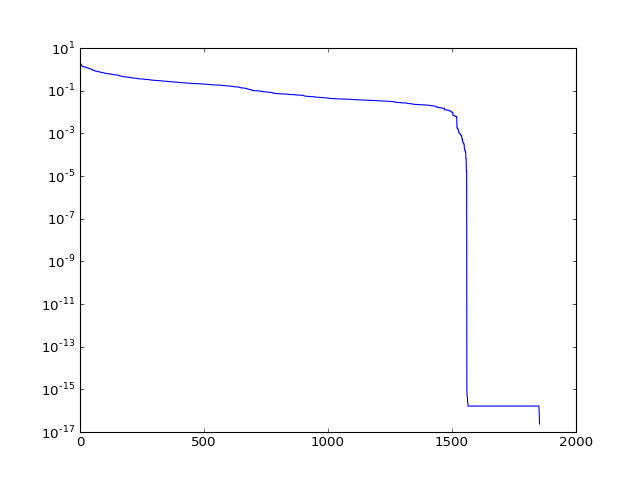

In [70]:
#A = logSolver.ls_phs.get_A()
A = linSolver.ls.get_A()
AtA = A[...,0].T.dot(A[...,0])
U,S,V = np.linalg.svd(AtA)
plt.figure()
plt.semilogy(S)


# Plotting

<IPython.core.display.Javascript object>


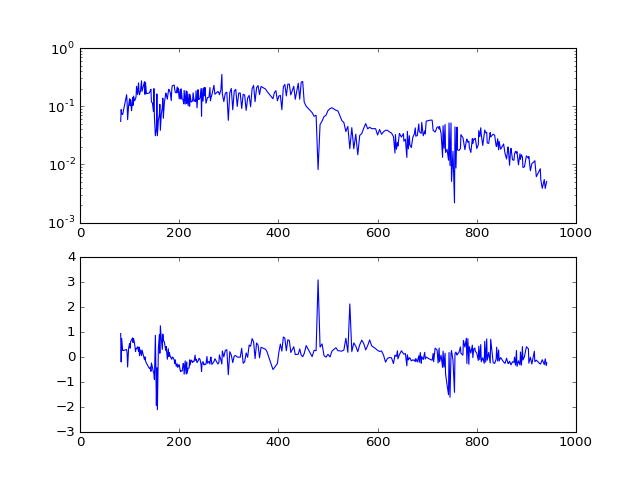

In [71]:
plt.figure()
plt.subplot(211)
plt.semilogy(chansSolved, np.abs(np.mean(bandpassSol,axis=1)))
plt.subplot(212)
plt.plot(chansSolved, np.angle(np.mean(bandpassSol,axis=1)))

<IPython.core.display.Javascript object>


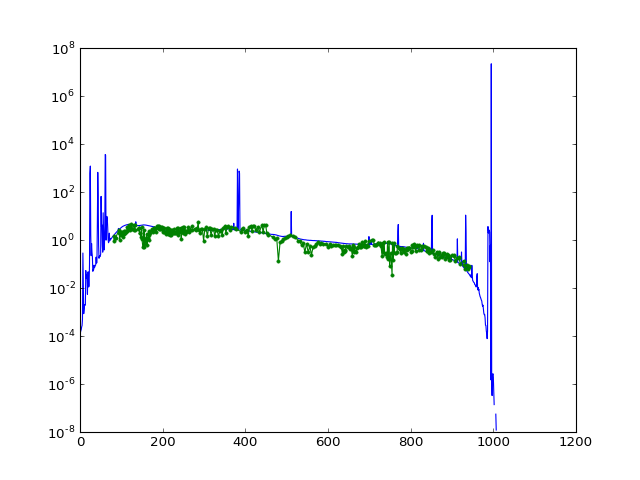

In [74]:
plt.figure()
meanVis = np.mean(np.abs([allUniqueVis['yy'][bl] for bl in allUniqueVis['yy'].keys()]), axis=(0,1))
plt.semilogy(meanVis / np.median(meanVis))
plt.semilogy(chansSolved, np.abs(np.mean(bandpassSol,axis=1)) / np.median(np.abs(np.mean(bandpassSol,axis=1))),'.-')
